In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import pyranges as pr

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
species = 'human'
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
lib_meta = od+expand(config['lr']['meta'], species=species)[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf_file = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]

gtex_gtf_file = od+expand(config['gtex']['gtf'], species='human')[0]

gene_subset = 'polya'
min_tpm = 1

species = 'mouse'
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
m_gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
m_lib_meta = od+expand(config['lr']['meta'], species=species)[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
m_ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]


## How many novel genes do we find?

In [142]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=1,
                      gene_subset=None)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2088: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Number of isos reported: 213476


In [143]:
df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

In [144]:
def get_gene_nov_colors(cats=None):
    c_dict = {'Known': '#009E73',
              'Intergenic': '#f49da3',
              'Fusion': '#8697bb',
              'Readthrough': '#8697bb'}
    order = ['Known', 'Fusion', 'Readthrough', 'Intergenic']

    c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order

In [145]:
temp = df[['gid', 'gene_novelty']].groupby('gene_novelty').nunique().reset_index().rename({'gid':'n_gid'}, axis=1)
temp

,gene_novelty,n_gid
0,Intergenic,68
1,Known,29386
2,Readthrough,79


In [146]:
79+68

147

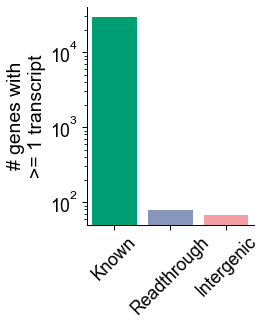

In [148]:
# bar plot for novel genes / category
c_dict, order = get_gene_nov_colors(cats=temp.gene_novelty.unique().tolist())
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(3,4))
ax = sns.barplot(data=temp, y='n_gid', x='gene_novelty',
                     palette=c_dict, order=order,
                     saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ylabel = '# genes with\n>= 1 transcript'
xlabel = ''
_ = ax.set(xlabel=xlabel, ylabel=ylabel)
ax.tick_params(axis="x", rotation=45)
ax.set_yscale('log')

fname = 'figures/human_gene_nov_bar.pdf'
fname = 'figures/human_gene_nov_bar.png'

plt.savefig(fname, dpi=500, bbox_inches='tight')

## Do transcripts from novel genes have complete ORFs?

In [130]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=1,
                      gene_subset=None)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2088: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Number of isos reported: 213476


In [131]:
df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

In [132]:
nov_df = df.loc[df.gene_novelty!='Known']
nov_df.rename({'annot_transcript_id':'tid'}, axis=1, inplace=True)
pp_df = pd.read_csv(pp_summary, sep='\t')
print(len(nov_df))
nov_df = nov_df.merge(pp_df, how='left', on='tid')
print(len(nov_df))

nov_df['full_orf'] = nov_df['full_orf'].fillna(False)

297
297


In [133]:
# how many transcripts expressed from novel genes have a complete ORF? 
temp = nov_df[['tid', 'full_orf', 'gene_novelty']].copy(deep=True)
temp = temp.groupby(['full_orf', 'gene_novelty']).nunique().reset_index().rename({'tid':'n_tids'}, axis=1)
temp

,full_orf,gene_novelty,n_tids
0,False,Intergenic,111
1,False,Readthrough,64
2,True,Intergenic,2
3,True,Readthrough,120


In [134]:
# how many transcripts expressed from novel genes have a complete ORF and no NMD?
temp = nov_df[['tid', 'full_orf', 'nmd', 'gene_novelty']].copy(deep=True)
temp = temp.loc[temp.full_orf==True]
temp.drop('full_orf', axis=1, inplace=True)
temp = temp.groupby(['nmd', 'gene_novelty']).nunique().reset_index().rename({'tid':'n_tids'}, axis=1)
temp

,nmd,gene_novelty,n_tids
0,False,Intergenic,2
1,False,Readthrough,101
2,True,Readthrough,19


In [135]:
nov_df['gid'] = nov_df.tid.str.split('[', expand=True)[0]

In [136]:
# how many novel genes have at least one transcript w/ a full ORF?
temp = nov_df[['gid', 'full_orf', 'gene_novelty']].copy(deep=True)
temp = temp.groupby(['gid', 'full_orf', 'gene_novelty']).max().reset_index()
temp = temp.groupby(['full_orf', 'gene_novelty']).nunique().reset_index().rename({'gid':'n_gids'}, axis=1)
temp2 = nov_df[['gid', 'gene_novelty']].groupby('gene_novelty').nunique().reset_index().rename({'gid':'n_total_gid'}, axis=1)
temp = temp.merge(temp2, how='left', on='gene_novelty')
temp['perc'] = (temp.n_gids/temp.n_total_gid)*100

temp3 = temp.copy(deep=True)
temp3 = temp3.loc[temp3.full_orf==True]
temp3['status'] = 'full_orf'
temp3


,full_orf,gene_novelty,n_gids,n_total_gid,perc,status
2,True,Intergenic,2,68,2.941176,full_orf
3,True,Readthrough,63,79,79.746835,full_orf


In [137]:
# how many novel genes have at least one transcript w/ a full ORF and no NMD?
temp = nov_df[['gid', 'nmd', 'full_orf', 'gene_novelty']].copy(deep=True)
temp = temp.loc[temp.full_orf==True]
temp.drop('full_orf', axis=1, inplace=True)
temp = temp.groupby(['gid', 'nmd', 'gene_novelty']).max().reset_index()
temp = temp.groupby(['nmd', 'gene_novelty']).nunique().reset_index().rename({'gid':'n_gids'}, axis=1)
temp2 = nov_df[['gid', 'gene_novelty']].groupby('gene_novelty').nunique().reset_index().rename({'gid':'n_total_gid'}, axis=1)
temp = temp.merge(temp2, how='left', on='gene_novelty')
temp['perc'] = (temp.n_gids/temp.n_total_gid)*100
temp['status'] = 'full_orf_no_nmd'
temp

,nmd,gene_novelty,n_gids,n_total_gid,perc,status
0,False,Intergenic,2,68,2.941176,full_orf_no_nmd
1,False,Readthrough,52,79,65.822785,full_orf_no_nmd
2,True,Readthrough,12,79,15.189873,full_orf_no_nmd


In [138]:
print(len(nov_df.loc[(nov_df.full_orf==True)&(nov_df.nmd==False)&(nov_df.gene_novelty=='Intergenic')].gid.unique()))
print(len(nov_df.loc[(nov_df.full_orf==True)&(nov_df.nmd==False)&(nov_df.gene_novelty=='Fusion')].gid.unique()))
print(len(nov_df.loc[(nov_df.full_orf==True)&(nov_df.nmd==True)&(nov_df.gene_novelty=='Fusion')].gid.unique()))

2
0
0


In [139]:
temp4

,nmd,gene_novelty,n_gids,n_total_gid,perc,status,full_orf
0,False,Fusion,52,79,65.822785,full_orf_no_nmd,NaN
1,False,Intergenic,2,68,2.941176,full_orf_no_nmd,NaN
2,NaN,Fusion,63,79,79.746835,full_orf,True
3,NaN,Intergenic,2,68,2.941176,full_orf,True


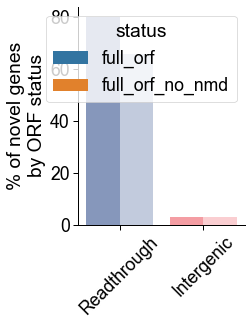

In [140]:
temp3_5 = temp.loc[temp.nmd==False].copy(deep=True)
temp4 = pd.concat([temp3_5, temp3], axis=0)

status_order = ['full_orf', 'full_orf_no_nmd']
temp4['status'] = temp4['status'].astype(str).astype('category')
temp4['status'] = temp4['status'].cat.reorder_categories(status_order, ordered=True)

c_dict, order = get_gene_nov_colors(temp4.gene_novelty.unique().tolist())
temp4['gene_novelty'] = temp4['gene_novelty'].astype(str).astype('category')
temp4['gene_novelty'] = temp4['gene_novelty'].cat.reorder_categories(order, ordered=True)

plt.figure(figsize=(3,4))
ax = sns.barplot(temp4, y='perc', x='gene_novelty', hue='status')
for bar_group, cat in zip(ax.containers, order):
        for bar, cat2 in zip(bar_group, order):
            c = c_dict[cat2]
            c_dict_2, order_2 = get_shade_colors(c, order)
            bar.set_facecolor(c_dict_2[cat])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ylabel = '% of novel genes\nby ORF status'
xlabel = ''
_ = ax.set(xlabel=xlabel, ylabel=ylabel)
ax.tick_params(axis="x", rotation=45)

fname = 'figures/human_gene_nov_orf_bar.pdf'
# fname = 'figures/human_gene_nov_bar.png'

plt.savefig(fname, dpi=500, bbox_inches='tight')

## What do expression profiles of novel genes vs. known genes look like?

In [179]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=1,
                      gene_subset=None)

df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

# sum up expression across gids
df.drop('annot_transcript_id', axis=1, inplace=True)
df = df.groupby(['gid', 'gene_novelty']).sum().reset_index()
df.drop('index', axis=1, inplace=True)

# get max tpm / gene
datasets = get_datasets('human')
df['max_tpm'] = df[datasets].max(axis=1)
df.drop(datasets, axis=1, inplace=True)

# add biotypes
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df = gtf_df[['gid_stable', 'biotype_category']]
df = df.merge(gtf_df, how='left', left_on='gid', right_on='gid_stable')
df.head()

,gid,gene_novelty,max_tpm,gid_stable,biotype_category
0,ENSG00000000003,Known,1232.992404,ENSG00000000003,protein_coding
1,ENSG00000000005,Known,4.925437,ENSG00000000005,protein_coding
2,ENSG00000000419,Known,229.887061,ENSG00000000419,protein_coding
3,ENSG00000000457,Known,32.773319,ENSG00000000457,protein_coding
4,ENSG00000000460,Known,105.361669,ENSG00000000460,protein_coding


In [180]:
polya_cats = ['protein_coding', 'lncRNA', 'pseudogene']
df = df.loc[(df.biotype_category.isin(polya_cats))|(df.gene_novelty!='Known')]
df['gene_status'] = df['gene_novelty']
df.loc[df.gene_novelty=='Known', 'gene_status'] = df.loc[df.gene_novelty=='Known', 'biotype_category']
df['log2_max_tpm'] = np.log2(df.max_tpm)

In [181]:
df.gene_status.unique()

array(['protein_coding', 'pseudogene', 'lncRNA', 'Intergenic',
       'Readthrough'], dtype=object)

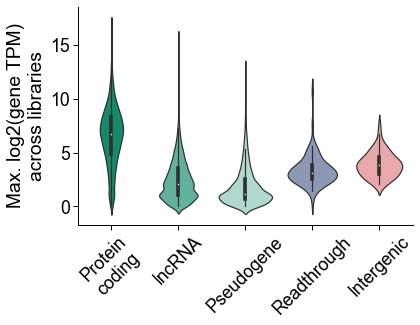

In [199]:
# violin
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
sns.set_context('paper', font_scale=2)

ic_colors, _ = get_ic_nov_colors()
c = ic_colors['Known']
m = {'protein_coding': 'Protein coding',
     'lncRNA': 'lncRNA', 'pseudogene': 'Pseudogene', 'Readthrough':'Readthrough',
     'Intergenic': 'Intergenic'}
df['gene_status_hr'] = df.gene_status.map(m)
cats = ['Protein coding', 'lncRNA', 'Pseudogene']
c_dict, order = get_shade_colors(c, cats)
c_dict_2, order_2 = get_gene_nov_colors()
c_dict['Readthrough'] = c_dict_2['Readthrough']
c_dict['Intergenic'] = c_dict_2['Intergenic']

order = ['Protein coding', 'lncRNA', 'Pseudogene', 'Readthrough', 'Intergenic']
labels = ['Protein\ncoding', 'lncRNA', 'Pseudogene', 'Readthrough', 'Intergenic', ]

ax = sns.violinplot(df, x='gene_status_hr', y='log2_max_tpm',
                 order=order, palette=c_dict, alpha=1)
ax.set(ylabel='Max. log2(gene TPM)\nacross libraries', xlabel='')
# ax.legend.remove()
# ax.get_legend().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis="x", rotation=45)
ax.set_xticklabels(labels)

fname = 'figures/max_gene_expression_by_gene_status.pdf'
plt.savefig(fname, dpi=500)

In [200]:
df[['gene_status', 'log2_max_tpm']].groupby('gene_status').median()

,log2_max_tpm
gene_status,
Intergenic,3.842002
Readthrough,3.136414
lncRNA,2.092549
protein_coding,6.755006
pseudogene,1.180744


## What does transcriptional diversity look like for known and novel readthrough guys?

In [214]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=1,
                      gene_subset=None)

df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'
df.head()

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2088: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Number of isos reported: 213476


,index,annot_transcript_id,hffc6_1_2,mucosa_of_descending_colon_1_1,hl60_m1_12hr_1_2,ovary_3_1,hct116_1_1,hl60_m2_24hr_1_2,calu3_1_1,caco2_1_2,...,h1_1_3,ocily7_1_2,heart_left_ventricle_4_1,h9_chondro_1_1,pgp1_1_1,lower_lobe_of_right_lung_1_1,a673_1_2,hepg2_1_1,gid,gene_novelty
0,0,"ENSG00000000003[1,1,1]",0.000000,0.000000,0.0,0.000000,1.078233,0.0,1.868680,10.064443,...,9.228966,0.0,0.000000,0.837785,0.000000,1.169899,2.510343,3.089794,ENSG00000000003,Known
1,1,"ENSG00000000003[1,1,5]",9.581481,68.713567,0.0,20.443209,8.625867,0.0,36.439267,84.541318,...,24.226036,0.0,4.362171,5.864493,25.636599,5.849493,33.471235,43.257112,ENSG00000000003,Known
2,2,"ENSG00000000003[1,1,6]",1.596913,1.908710,0.0,0.000000,3.234700,0.0,1.868680,8.051554,...,1.153621,0.0,0.000000,0.000000,0.000000,1.169899,0.836781,3.089794,ENSG00000000003,Known
3,3,"ENSG00000000003[1,1,7]",30.341356,114.522612,0.0,23.850410,26.955834,0.0,102.777420,168.076192,...,80.753453,0.0,5.816228,15.917910,51.273199,7.019391,46.022948,82.188513,ENSG00000000003,Known
4,4,"ENSG00000000003[1,1,8]",25.550616,169.875209,0.0,20.443209,17.251734,0.0,74.747214,181.159967,...,43.837589,0.0,4.362171,16.755695,34.182133,7.019391,27.613769,40.167319,ENSG00000000003,Known


In [204]:
df[['gene_novelty', 'gid']].groupby('gene_novelty').nunique()

,gid
gene_novelty,
Intergenic,68
Known,29386
Readthrough,79


In [215]:
df_back = df.copy(deep=True)

In [206]:
# get only transcripts from novel genes
df = df.loc[df.gene_novelty!='Known']
tids = df.annot_transcript_id.tolist()

In [207]:
ca = cerberus.read(cerberus_h5)
df = ca.get_subset_triplets(tids, source='obs_readthrough')

In [208]:
df.to_csv('readthrough_triplets.tsv', sep='\t')

In [262]:
trip_df = pd.read_csv('readthrough_triplets.tsv', sep='\t')

In [263]:
trip_df = trip_df.merge(df[['gid', 'gene_novelty']], 
                        how='left',
                        left_on='gene_id',
                        right_on='gid')

In [264]:
trip_df.head()

,Unnamed: 0,gene_id,n_iso,n_tss,n_ic,n_tes,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,source,gid,gene_novelty
0,0,TALONG000058996,2,1,2,2,1.333333,0.230769,0.461538,0.307692,mixed,obs_readthrough,TALONG000058996,Intergenic
1,0,TALONG000058996,2,1,2,2,1.333333,0.230769,0.461538,0.307692,mixed,obs_readthrough,TALONG000058996,Intergenic
2,1,TALONG000059039,1,1,1,1,1.000000,0.333333,0.333333,0.333333,simple,obs_readthrough,TALONG000059039,Intergenic
3,2,TALONG000059465,4,1,4,2,2.666667,0.176471,0.352941,0.470588,mixed,obs_readthrough,TALONG000059465,Intergenic
4,2,TALONG000059465,4,1,4,2,2.666667,0.176471,0.352941,0.470588,mixed,obs_readthrough,TALONG000059465,Intergenic


In [275]:
temp2.sector.unique()

array(['mixed', 'simple', 'splicing'], dtype=object)

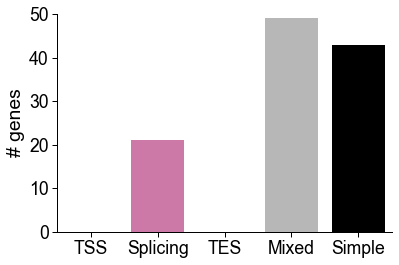

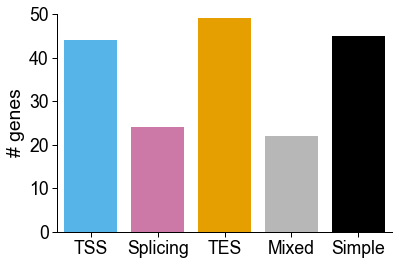

In [285]:
temp = trip_df[['gene_novelty', 'gid', 'sector']].groupby(['gene_novelty', 'sector']).count().reset_index().rename({'gid':'n_genes'}, axis=1)
c_dict_2, order_2 = get_sector_colors()
for n in temp.gene_novelty.unique().tolist():
    temp2 = temp.loc[temp.gene_novelty==n].copy(deep=True)
    ax = sns.barplot(data=temp2, x='sector', y='n_genes', saturation=1, order=order_2, palette=c_dict_2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(ylabel='# genes', xlabel='', ylim=(0,50))
    labels = []
    for o in order_2:
        if o == 'tss' or o == 'tes':
            l = o.upper()
        else:
            l = o.capitalize()
        labels.append(l)
    ax.set_xticklabels(labels)
    fname = f'figures/{n}_genes_per_sector.pdf'
    plt.savefig(fname, dpi=500)
    plt.show()
    
    # plt.clf()
    

In [273]:
c_dict_2

{'tss': '#56B4E9',
 'splicing': '#CC79A7',
 'tes': '#E69F00',
 'simple': '#000000',
 'mixed': '#b7b7b7'}

In [227]:
trip_df.loc[(trip_df.gene_novelty=='Intergenic')&(trip_df.sector=='tss')]

,Unnamed: 0,gene_id,n_iso,n_tss,n_ic,n_tes,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,source,gid,gene_novelty


## What about just plain old number of transcripts detected / gene ? 

In [229]:
trip_df = pd.read_csv('readthrough_triplets.tsv', sep='\t')

In [230]:
trip_df = trip_df.merge(df[['gid', 'gene_novelty']], 
                        how='left',
                        left_on='gene_id',
                        right_on='gid')

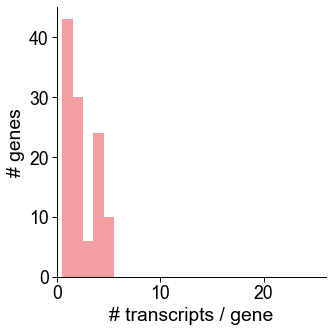

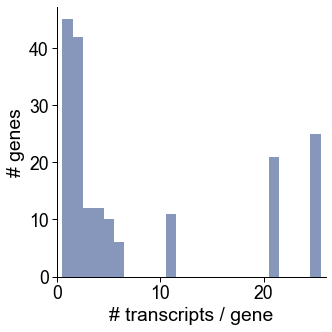

In [261]:
c_dict, order = get_gene_nov_colors(cats=trip_df.gene_novelty.unique().tolist())

for n in trip_df.gene_novelty.unique():
    temp2 = trip_df.loc[trip_df.gene_novelty==n].copy(deep=True)
    ax = sns.displot(temp2, x='n_iso', binwidth=1, alpha=1, linewidth=0, discrete=True,
                     color=c_dict[n])
    # temp2 = temp2[['gene_novelty', 'n_iso']].groupby('n_iso').count().reset_index()
    # ax = sns.catplot(temp2, y='gene_novelty', x='n_iso', alpha=1, kind='bar', color=c_dict[n])
    ax.set(ylabel='# genes', xlabel='# transcripts / gene', xlim=(0,26))
    # plt.show()
    # plt.clf()
    fname = f'figures/{n}_transcripts_per_gene.pdf'
    plt.savefig(fname, dpi=500)

## How many novel readthrough loci do we detect?

In [20]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df, 
                         how='iso',
                         min_tpm=1,
                         gene_subset=None)
df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
df = df.merge(ab_df, how='left', on='gid')

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2086: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Number of isos reported: 213476


In [21]:
n = len(df.loc[df.gene_novelty=='Fusion'].gid.unique())
print(f'Found {n} fusion loci in human')

Found 79 fusion loci in human


## How often do our intergenic novel gene bodies intersect with those found in GTEx?

In [361]:
samples = get_gtex_match_samples()

In [362]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=1,
                      gene_subset=None,
                      sample=samples)

df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'
# nov_df = df.loc[df.gene_novelty!='Known']
nov_df = df.loc[df.gene_novelty=='Intergenic']
nov_df.rename({'annot_transcript_id':'tid'}, axis=1, inplace=True)

Calculating iso TPM values
Subsetting for ['adipose', 'brain', 'brain_ad', 'hmec', 'mcf10a', 'mcf7', 'heart', 'liver', 'lung', 'muscle', 'h9_panc_beta', 'h9_panc_progen', 'panc1', 'k562'] samples


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2088: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 173776
Number of isos reported: 173776


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [363]:
nov_df[['gid', 'gene_novelty']].groupby('gene_novelty').nunique().reset_index().rename({'gid':'n_genes'}, axis=1)

,gene_novelty,n_genes
0,Intergenic,27


In [369]:
# # get the gene body coords for the novel genes in both cerberus and gtex
# gtf_df = pr.read_gtf(gtf_file, as_df=True)
# gtf_df = gtf_df.loc[gtf_df.Feature=='gene']
# gtf_df = gtf_df.loc[gtf_df.gene_id.isin(nov_df.gid.tolist())]
# gtf_df.to_csv('cerberus_gtf_gene_bodies.tsv', sep='\t', index=False)

In [366]:
# # get gene body coords from gtex
# gtex_df = pr.read_gtf(gtex_gtf_file, as_df=True)
# fwd, rev = cerberus.get_stranded_gtf_dfs(gtex_df)
# fwd = fwd[['gene_id', 'Start', 'End']].groupby('gene_id').agg({'Start':min,
#                                                                'End':max}).reset_index()
# rev = rev[['gene_id', 'Start', 'End']].groupby('gene_id').agg({'Start':max,
#                                                                'End':min}).reset_index()
# temp = pd.concat([fwd, rev], axis=0)
# gtex_df.drop(['Start', 'End'], axis=1, inplace=True)
# gtex_df = gtex_df.merge(temp, how='left', on='gene_id')
# gtex_df.to_csv('gtex_gtf_gene_bodies.tsv', sep='\t', index=False)

In [370]:
gtf_df = pd.read_csv('cerberus_gtf_gene_bodies.tsv', sep='\t')
gtex_df = pd.read_csv('gtex_gtf_gene_bodies.tsv', sep='\t')

In [371]:
len(gtf_df.index)

27

In [372]:
gtf_df = gtf_df[['Chromosome', 'Strand', 'Start', 'End', 'gene_id']].drop_duplicates()
gtex_df = gtex_df[['Chromosome', 'Strand', 'Start', 'End', 'gene_id']].drop_duplicates()

In [373]:
gtf_df = pr.PyRanges(gtf_df)
gtex_df = pr.PyRanges(gtex_df)

In [374]:
# gtf_df = pr.PyRanges(gtf_df.df)
# gtex_df = pr.PyRanges(gtex_df.df)
df = gtf_df.join(gtex_df, 
                      strandedness='same', 
                report_overlap=True,
                how='left')

In [377]:
df = df.df

In [378]:
df.loc[df.Start_b!=-1]

,Chromosome,Strand,Start,End,gene_id,Strand_b,Start_b,End_b,gene_id_b,Overlap


## How many GENCODE genes engage in readthrough transcription?

In [379]:
df = pr.read_gtf(ref_gtf, duplicate_attr=True)

In [380]:
df = df.df
df = df.loc[df.Feature=='transcript']

In [381]:
# is it possible that a not all transcripts from a given gene are called as readthrough? 
temp = df[['gene_id','transcript_id','tag']]
temp['readthrough_transcript'] = temp.tag.str.contains('readthrough_transcript')
temp.drop('tag', axis=1, inplace=True)

gids = temp.loc[temp.readthrough_transcript==True]
temp.loc[(temp.gene_id.isin(gids))&(temp.readthrough_transcript==False)]

# nope
assert len(temp.loc[(temp.gene_id.isin(gids))&(temp.readthrough_transcript==False)]) == 0

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [394]:
# rt_df = df.loc[(df.tag.notnull())&(df.tag.str.contains('readthrough_transcript'))]
# rt_df = rt_df[['gene_id', 'transcript_id']].drop_duplicates()
# rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gene_id')
# n = len(rt_df.gene_id.unique().tolist())
# print(f'Gencode v40 has {n} genes w/ annotated readthrough transcription')
# n = len(rt_df.transcript_id.unique().tolist())
# print(f'Gencode v40 has {n} transcripts w/ annotated readthrough transcription')

In [26]:
rt_df.head()

,gene_id,transcript_id,gid_stable
10466,ENSG00000251503.8,ENST00000400900.6,ENSG00000251503
10481,ENSG00000251503.8,ENST00000470413.6,ENSG00000251503
10494,ENSG00000251503.8,ENST00000602787.6,ENSG00000251503
10511,ENSG00000251503.8,ENST00000602296.6,ENSG00000251503
10524,ENSG00000251503.8,ENST00000465026.1,ENSG00000251503


In [383]:
rt_df.to_csv('v40_readthrough_df.tsv', sep='\t', index=False)

## How many transcripts w/ annotated readthrough transcription do we detect?

In [386]:
df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df = df.loc[df.readthrough_transcript==True]
n = len(rt_df.gid.unique().tolist())
print(f'Gencode v40 has {n} genes w/ annotated readthrough transcription')
n = len(rt_df.tid.unique().tolist())
print(f'Gencode v40 has {n} transcripts w/ annotated readthrough transcription')

Gencode v40 has 981 genes w/ annotated readthrough transcription
Gencode v40 has 2075 transcripts w/ annotated readthrough transcription


In [387]:
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df, tids = get_tpm_table(ab_df, 
                         how='iso',
                         min_tpm=1,
                         gene_subset=None)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2088: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Number of isos reported: 213476


In [388]:
ab_df = ab_df.reset_index()
ab_df.rename({'annot_transcript_id':'tid'}, axis=1, inplace=True)

In [389]:
# % of rt gencode transcripts
n = len(rt_df.index)
n_num = len(ab_df.loc[ab_df.tid.isin(rt_df.tid.tolist())].index)
print('{:.2f}% ({}/{}) of GENCODE v40 readthrough transcripts were observed'.format((n_num/n)*100, n_num, n))

14.02% (291/2075) of GENCODE v40 readthrough transcripts were observed


In [390]:
# % of rt gencode genes
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
ab_df['gid'] = ab_df.tid.str.split('[', expand=True)[0]
n = len(rt_df.gid_stable.unique().tolist())
n_num = len(ab_df.loc[ab_df.gid.isin(rt_df.gid_stable.tolist())].gid.unique().tolist())
print('{:.2f}% ({}/{}) of GENCODE v40 readthrough genes were observed'.format((n_num/n)*100, n_num, n))

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


30.68% (301/981) of GENCODE v40 readthrough genes were observed


## How many novel readthrough transcripts do we add to annotated readthrough genes?

In [396]:
print(len(rt_df.gid_stable.unique()))

981


In [392]:
# % of rt gencode transcripts
n_num = len(ab_df.loc[(~ab_df.tid.isin(rt_df.tid.tolist()))&(ab_df.gid.isin(rt_df.gid_stable.tolist())), 'tid'].unique().tolist())
print(f'We detect {n_num} novel transcripts of annotated readthrough genes')

We detect 880 novel transcripts of annotated readthrough genes


In [393]:
ab_df.loc[(~ab_df.tid.isin(rt_df.tid.tolist()))&(ab_df.gid.isin(rt_df.gid_stable.tolist()))].head()

,tid,hffc6_1_2,mucosa_of_descending_colon_1_1,hl60_m1_12hr_1_2,ovary_3_1,hct116_1_1,hl60_m2_24hr_1_2,calu3_1_1,caco2_1_2,huvec_1_1,...,posterior_vena_cava_2_1,h1_1_3,ocily7_1_2,heart_left_ventricle_4_1,h9_chondro_1_1,pgp1_1_1,lower_lobe_of_right_lung_1_1,a673_1_2,hepg2_1_1,gid
1591,"ENSG00000006194[1,1,1]",0.000000,0.00000,3.132198,3.407201,11.860567,5.428351,0.934340,5.032221,2.891522,...,13.106561,12.689828,7.230440,11.632455,10.053417,3.418213,12.868884,5.857466,11.123257,ENSG00000006194
1592,"ENSG00000006194[1,3,2]",0.000000,0.00000,1.044066,0.000000,0.000000,0.000000,0.000000,0.000000,0.578304,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.617959,ENSG00000006194
1593,"ENSG00000006194[1,4,1]",3.193827,1.90871,4.176263,0.000000,14.017034,1.357088,11.212082,6.038666,5.204740,...,8.737707,3.460862,4.820293,0.000000,10.891202,5.127320,5.849493,11.714932,14.831010,ENSG00000006194
1594,"ENSG00000006194[1,4,3]",0.000000,0.00000,0.000000,0.000000,1.078233,0.000000,0.934340,0.000000,0.000000,...,0.000000,1.153621,0.000000,0.000000,0.000000,0.000000,0.000000,0.836781,0.000000,ENSG00000006194
1595,"ENSG00000006194[1,5,5]",0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000006194


In [398]:
n_num = len(ab_df.loc[ab_df.gid.isin(rt_df.gid_stable.tolist())].index)
print(f'{n_num} transcripts detected from annotated readthrough genes total')

1171 transcripts detected from annotated readthrough genes total


In [399]:
1171-880

291

## How lowly-expressed are annotated readthrough genes compared to the genes that make them up? 

In [41]:
df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
df['gid_stable'] = cerberus.get_stable_gid(df, 'gid')
rt_df = df.loc[df.readthrough_transcript==True]
print(len(rt_df.gid.unique()))
print(len(rt_df.loc[rt_df.gname.str.contains('-')].gid.unique()))

981
144


In [42]:
# get only the ones with hyphen names, and their counterparts
rt_gids = rt_df.loc[rt_df.gname.str.contains('-'), 'gid_stable'].unique()
rt_gnames = rt_df.loc[rt_df.gid_stable.isin(rt_gids), 'gname'].str.split('-').explode().unique()
normal_gids = df.loc[df.gname.isin(rt_gnames), 'gid_stable'].unique()
print(len(rt_gids))
print(len(normal_gids))

144
280


In [43]:
ab_df = pd.read_csv(ab, sep='\t')
ab_df, inds = get_tpm_table(ab_df,
                        how='gene',
                        gene_subset=None,
                        min_tpm=1)

Calculating gene TPM values
Subsetting for novelty categories ['Known']


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # genes detected: 564934
# genes >= 1 tpm: 276567
Applying gene type and novelty subset
Number of genes reported: 37677


In [44]:
# label gene status and limit to RT-related genes
ab_df.reset_index(inplace=True)
ab_df['gene_status'] = False
ab_df.loc[ab_df.gid_stable.isin(rt_gids), 'gene_status'] = 'Readthrough'
ab_df.loc[ab_df.gid_stable.isin(normal_gids), 'gene_status'] = 'Readthrough\nparents'
# ab_df = ab_df.loc[ab_df.gene_status != False]


In [45]:
normal_gids[:5]

array(['ENSG00000033050', 'ENSG00000054219', 'ENSG00000059769',
       'ENSG00000062582', 'ENSG00000063438'], dtype=object)

In [46]:
ab_df[['gid_stable', 'gene_status']].groupby('gene_status').nunique().reset_index()

,gene_status,gid_stable
0,False,37272
1,Readthrough,134
2,Readthrough\nparents,271


In [47]:
ab_df = ab_df.loc[ab_df.gene_status != False]

In [48]:
datasets = get_datasets('human')
ab_df['max_tpm'] = ab_df[datasets].max(axis=1)
ab_df.drop(datasets, axis=1, inplace=True)
ab_df['log2_max_tpm'] = np.log2(ab_df.max_tpm)
ab_df.head()

,gid_stable,gene_status,max_tpm,log2_max_tpm
278,ENSG00000011052,Readthrough,51.302416,5.680955
452,ENSG00000026036,Readthrough,18.930535,4.242643
497,ENSG00000033050,Readthrough\nparents,290.654061,8.183159
721,ENSG00000054219,Readthrough\nparents,75.439215,6.237243
802,ENSG00000059769,Readthrough\nparents,31.942549,4.997408


In [51]:
get_gene_nov_colors()

({'Known': '#009E73', 'Intergenic': '#f49da3', 'Fusion': '#8697bb'},
 ['Known', 'Fusion', 'Intergenic'])

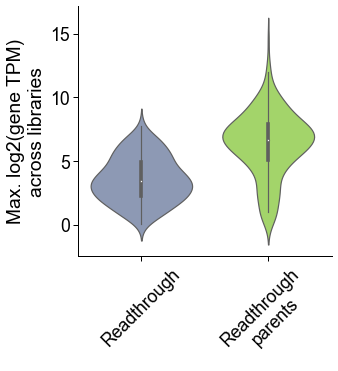

In [55]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

c_dict = {'Readthrough': get_gene_nov_colors()[0]['Fusion'],
          'Readthrough\nparents': '#a4e658'}

ax = sns.catplot(data=ab_df, x='gene_status', y='log2_max_tpm', kind='violin',  palette=c_dict, alpha=1)
ax.set(xlabel='', ylabel='Max. log2(gene TPM)\nacross libraries')
ax.tick_params(axis="x", rotation=45)


In [ ]:
# this is not a great way to do this unfortunately :(

## What does the expression of known readthrough loci look like compared to novel?

In [64]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=1,
                      gene_subset=None)

df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

# sum up expression across gids
df.drop('annot_transcript_id', axis=1, inplace=True)
df = df.groupby(['gid', 'gene_novelty']).sum().reset_index()
df.drop('index', axis=1, inplace=True)

# get max tpm / gene
datasets = get_datasets('human')
df['max_tpm'] = df[datasets].max(axis=1)
df.drop(datasets, axis=1, inplace=True)

# add biotypes
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df = gtf_df[['gid_stable', 'biotype_category']]
df = df.merge(gtf_df, how='left', left_on='gid', right_on='gid_stable')
df.head()

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Number of isos reported: 213476


,gid,gene_novelty,max_tpm,gid_stable,biotype_category
0,ENSG00000000003,Known,1232.992404,ENSG00000000003,protein_coding
1,ENSG00000000005,Known,4.925437,ENSG00000000005,protein_coding
2,ENSG00000000419,Known,229.887061,ENSG00000000419,protein_coding
3,ENSG00000000457,Known,32.773319,ENSG00000000457,protein_coding
4,ENSG00000000460,Known,105.361669,ENSG00000000460,protein_coding


In [72]:
# keep only known read through and novel readthrough
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
known_rt_gids = rt_df.gid_stable.unique().tolist()
df['gene_status'] = False
df.loc[df.gid.isin(known_rt_gids), 'gene_status'] = 'Known\nreadthrough'
df.loc[df.gene_novelty=='Readthrough', 'gene_status'] = 'Novel\nreadthrough'
df = df.loc[df.gene_status != False]
df[['gid', 'gene_status']].groupby('gene_status').nunique().reset_index()

,gene_status,gid
0,Known\nreadthrough,301
1,Novel\nreadthrough,79


In [75]:
df['log2_max_tpm'] = np.log2(df.max_tpm)

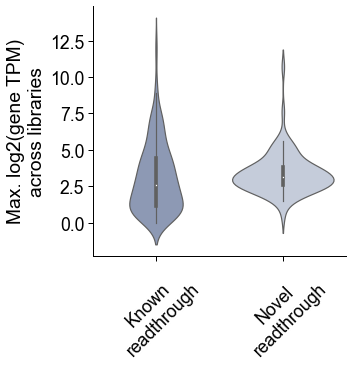

In [76]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

c_dict, order = get_shade_colors(get_gene_nov_colors()[0]['Fusion'], ['Known\nreadthrough', 'Novel\nreadthrough'])

ax = sns.catplot(data=df, x='gene_status', y='log2_max_tpm', kind='violin', 
                 palette=c_dict, alpha=1,
                 order=order)
ax.set(xlabel='', ylabel='Max. log2(gene TPM)\nacross libraries')
ax.tick_params(axis="x", rotation=45)
